# **TimeGAN**
Unofficial implementation in PyTorch.

Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

Notebook Author: https://github.com/haufjan

### **Import**

In [1]:
import os
import time
from itertools import chain, cycle

import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib as mpl
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm

### **Random Seeds**

In [2]:
np.random.seed(42)
torch.manual_seed(42)

### **Functions**

In [3]:
def loading(*files: str) -> pd.DataFrame:
    """
    Load data from csv file
    """
    return_list = []
    for file in files:
        path = f'{file}' if file.endswith('csv') else f'{file}.csv'
        return_list.extend([pd.read_csv(path)])

    return return_list if len(return_list) > 1 else return_list.pop()

In [4]:
def preprocessing(*inputs: tuple, horizon: int, shuffle_stack: bool = True, random_state: int = None) -> np.ndarray:
    """
    Conduct preprocessing: scale data, slice data into sequences and shuffle data stack
    """
    return_list = []
    for data, bool_scale in inputs:
        #Create Minimum-Maximum scaler
        if bool_scale:
            scaler = MinMaxScaler().fit(data)
            data = scaler.transform(data)
            print('\nMaximum values:\n', scaler.data_max_, '\nMinimum values:\n', scaler.data_min_)

        #Create a list holding the sequences defined by sliding window of width = horizon and stack to a 3-dimensional array (batch, horizon, feature)
        data_stack = np.stack([data[i:i+horizon] for i in range(len(data) - horizon)])

        if shuffle_stack:
            #In TimeGAN code the dataset is mixed to make it similar to independent and identically distributed (iid)
            data_stack = shuffle(data_stack, random_state=random_state)

        return_list.extend([data_stack, scaler.data_max_, scaler.data_min_]) if bool_scale else return_list.extend([data_stack])

    return return_list if len(return_list) > 1 else return_list.pop()

In [5]:
def low_dimensional_representation(data_ori: np.ndarray, data_gen: np.ndarray, technique: str) -> np.ndarray:
    """
    Transform data into low-dimensional representation
    """
    assert technique in ['pca', 'tsne']

    sample_no = min([1000, len(data_ori)])
    idx = np.random.permutation(len(data_ori))[:sample_no]
    data_ori, data_gen = np.asarray(data_ori)[idx], np.asarray(data_gen)[idx]
    no, seq_len, dim = data_ori.shape

    prep_data = np.array([np.reshape(np.mean(data_ori[i,:,:], 1), [1,seq_len]).flatten().tolist() for i in range(sample_no)])
    prep_data_hat = np.array([np.reshape(np.mean(data_gen[i,:,:], 1), [1,seq_len]).flatten().tolist() for i in range(sample_no)])

    if technique == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)

        return pca.transform(prep_data), pca.transform(prep_data_hat)

    elif technique == 'tsne':
        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, max_iter = 300)
        tsne_result = tsne.fit_transform(prep_data_final)

        return tsne_result[:sample_no], tsne_result[sample_no:]

In [6]:
def plot_distribution_estimate(lowdim_data_ori: np.ndarray, lowdim_data_gen: np.ndarray, technique: str) -> None:
    """
    Visualize distribution estimate via sampled data points
    """
    fig, ax = plt.subplots()
    #Use rasterized Line2D Artist here instead of scatter. Espacially benefitial when exporting the plot as pdf file (or other vector graphics).
    ax.add_line(mpl.lines.Line2D(lowdim_data_ori[:,0], lowdim_data_ori[:,1], ls='', marker='o', markersize=3, c = 'red', alpha = 0.2, rasterized=True, label='Original'))
    ax.add_line(mpl.lines.Line2D(lowdim_data_gen[:,0], lowdim_data_gen[:,1], ls='', marker='o', markersize=3, c = 'blue', alpha = 0.2, rasterized=True, label='Generated'))
    ax.autoscale_view()
    ax.set_xlabel(f'x-{technique}')
    ax.set_ylabel(f'y-{technique}')
    ax.legend()
    fig.show()

### **Load and prepare Data**

In [7]:
#Data set
data = loading(os.path.join('stock_data'))

#Squence length
HORIZON = 24

#Flip stock_data to make it chronological
data = np.asarray(data)[::-1]

#Preprocess data
data_train, max_val, min_val = preprocessing((data, True), horizon=HORIZON)


Maximum values:
 [1.27100000e+03 1.27389001e+03 1.24902002e+03 1.26832996e+03
 1.26832996e+03 8.27681000e+07] 
Minimum values:
 [  49.274517   50.541279   47.669952   49.681866   49.681866 7900.      ]


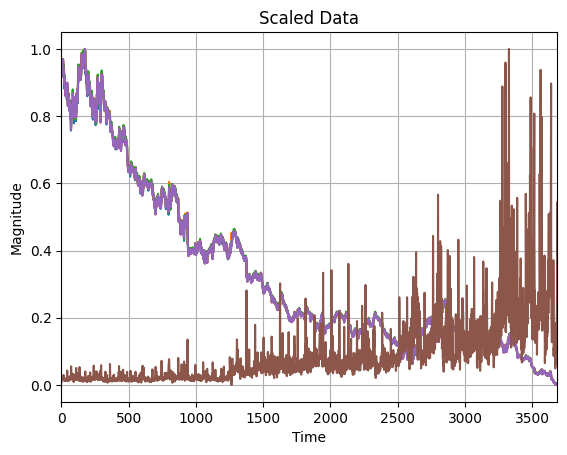

In [8]:
#Visualize scaled training data
fig, ax = plt.subplots()
ax.plot((data - min_val)/(max_val - min_val))
ax.set_xlim(0, len(data))
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Scaled Data')
ax.grid(True)
fig.show()

### **Device**

In [9]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

Using cuda device


### **Networks**

##### **Embedder**

In [10]:
class Embedder(nn.Module):
    def __init__(self, module_name, input_features, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Recovery**

In [11]:
class Recovery(nn.Module):
    def __init__(self, module_name, input_features, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, input_features),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Generator**

In [12]:
class Generator(nn.Module):
    def __init__(self, module_name, input_features, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Supervisor**

In [13]:
class Supervisor(nn.Module):
    def __init__(self, module_name, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers-1, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers-1, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Discriminator**

In [14]:
class Discriminator(nn.Module):
    def __init__(self, module_name, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=False, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=False, batch_first=True)
        else:
            raise Exception()
        #If bidirectional = True
        # self.model = nn.Linear(2*hidden_dim, 1)
        #If bidirectional = False
        self.model = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

### **Loss Functions**

In [15]:
def embedder_loss(x, x_tilde):
    return 10*torch.sqrt(nn.MSELoss()(x_tilde, x))

In [16]:
def supervised_loss(h, h_hat_supervise):
    return nn.MSELoss()(h_hat_supervise[:,:-1,:], h[:,1:,:])

In [17]:
def generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat):
    gamma = 1
    fake = torch.ones_like(y_fake, dtype=torch.float32, device=device, requires_grad=False)

    #1. Unsupervised generator loss
    g_loss_u = nn.BCEWithLogitsLoss()(y_fake, fake)
    g_loss_u_e = nn.BCEWithLogitsLoss()(y_fake_e, fake)

    #2. Supervised loss
    g_loss_s = nn.MSELoss()(h_hat_supervise[:,:-1,:], h[:,1:,:])

    #3. Two moments
    g_loss_v1 = torch.mean(torch.abs(torch.sqrt(torch.std(x_hat, dim=0)) - torch.sqrt(torch.std(x, dim=0))))
    g_loss_v2 = torch.mean(torch.abs(torch.mean(x_hat, dim=0) - torch.mean(x, dim=0)))
    g_loss_v = g_loss_v1 + g_loss_v2

    return g_loss_u + gamma*g_loss_u_e + 100*torch.sqrt(g_loss_s) + 100*g_loss_v

In [18]:
def discriminator_loss(y_real, y_fake, y_fake_e):
    gamma = 1
    valid = torch.ones_like(y_real, dtype=torch.float32, device=device, requires_grad=False)
    fake = torch.zeros_like(y_fake, dtype=torch.float32, device=device, requires_grad=False)

    d_loss_real = nn.BCEWithLogitsLoss()(y_real, valid)
    d_loss_fake = nn.BCEWithLogitsLoss()(y_fake, fake)
    d_loss_fake_e = nn.BCEWithLogitsLoss()(y_fake_e, fake)

    return d_loss_real + d_loss_fake + d_loss_fake_e*gamma

### **TimeGAN**

In [19]:
class TimeGAN(nn.Module):
    def __init__(self,
                 module_name: str = 'gru',
                 input_features: int = 1,
                 hidden_dim: int = 8,
                 num_layers: int = 3,
                 epochs: int = 100,
                 batch_size: int = 128,
                 learning_rate: float = 1e-3):

        super().__init__()
        #Parameters
        self.module_name = module_name
        self.input_features = input_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        #Networks
        self.embedder = Embedder(module_name, input_features, hidden_dim, num_layers)
        self.recovery = Recovery(module_name, input_features, hidden_dim, num_layers)
        self.generator = Generator(module_name, input_features, hidden_dim, num_layers)
        self.supervisor = Supervisor(module_name, hidden_dim, num_layers)
        self.discriminator = Discriminator(module_name, hidden_dim, num_layers)

        #Optimizers
        self.optimizer_e = torch.optim.Adam(chain(self.embedder.parameters(), self.recovery.parameters()), lr=learning_rate)
        self.optimizer_g = torch.optim.Adam(chain(self.generator.parameters(), self.supervisor.parameters()), lr=learning_rate)
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)

        #Loss functions
        self.embedder_loss = embedder_loss
        self.supervised_loss = supervised_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

        #Auxiliary
        self.fitting_time = None
        self.losses = []

    def fit(self, data_train: np.ndarray):
        """
        Train TimeGAN model in three subsequent training phases
        """
        self.fitting_time = time.time()
        data_train = tensor(data_train, dtype=torch.float32, device=device)

        #1. Embedding network training
        print('Start Embedding Network Training')
        for epoch, frame in zip(range(self.epochs), cycle(r'-\|/-\|/')):
            batches_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_e = []
            for x in batches_train:
                self.optimizer_e.zero_grad()

                h = self.embedder(x)
                x_tilde = self.recovery(h)
                e_loss = self.embedder_loss(x, x_tilde)

                e_loss.backward()
                self.optimizer_e.step()

                loss_e.append(e_loss.item())

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs, '| loss_e', f'{np.mean(loss_e):12.9f}')
            else:
                print('\r', frame, sep='', end='', flush=True)

        print('Finished Embedding Network Training\n')

        #2. Training using only supervised loss
        print('Start Training with Supervised Loss Only')
        for epoch, frame in zip(range(self.epochs), cycle(r'-\|/-\|/')):
            batches_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_g = []
            for x in batches_train:
                self.optimizer_g.zero_grad()

                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)

                g_loss = self.supervised_loss(h, h_hat_supervise)

                g_loss.backward()
                self.optimizer_g.step()

                loss_g.append(g_loss.item())

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs, '| loss_g', f'{np.mean(loss_g):12.9f}')
            else:
                print('\r', frame, sep='', end='', flush=True)

        print('Finished Training with Supervised Loss Only\n')

        #3. Joint training
        print('Start Joint Training')
        for epoch, frame in zip(range(self.epochs), cycle(r'-\|/-\|/')):
            loss_g = []
            loss_e = []
            #Traing generator twice more than discriminator
            for kk in range(2):
                dataset = TensorDataset(data_train, torch.rand(data_train.shape, dtype=torch.float32, device=device))

                batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

                self.train()
                for x, z in batches_train:
                    self.optimizer_g.zero_grad()

                    h = self.embedder(x)
                    e_hat = self.generator(z)
                    h_hat = self.supervisor(e_hat)
                    h_hat_supervise = self.supervisor(h)
                    x_hat = self.recovery(h_hat)
                    y_fake = self.discriminator(h_hat)
                    y_fake_e = self.discriminator(e_hat)

                    g_loss = self.generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat)

                    g_loss.backward()
                    self.optimizer_g.step()

                    loss_g.append(g_loss.item())

                    self.optimizer_e.zero_grad()

                    h = self.embedder(x)
                    h_hat_supervise = self.supervisor(h)
                    x_tilde = self.recovery(h)

                    e_loss = self.embedder_loss(x, x_tilde) + 0.1*self.supervised_loss(h, h_hat_supervise)

                    e_loss.backward()
                    self.optimizer_e.step()

                    loss_e.append(e_loss.item())

            dataset = TensorDataset(data_train, torch.rand(data_train.shape, dtype=torch.float32, device=device))

            batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_d = []
            for x, z in batches_train:
                self.optimizer_d.zero_grad()

                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)

                y_fake = self.discriminator(h_hat)
                y_real = self.discriminator(h)
                y_fake_e = self.discriminator(e_hat)

                d_loss = self.discriminator_loss(y_real, y_fake, y_fake_e)

                loss_d.append(d_loss.item())

                if d_loss > 0.15:
                    d_loss.backward()
                    self.optimizer_d.step()

            self.losses.append([np.mean(loss_g), np.mean(loss_e), np.mean(loss_d)])

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_g', f'{np.mean(loss_g):12.9f}',
                      '| loss_e', f'{np.mean(loss_e):12.9f}',
                      '| loss_d', f'{np.mean(loss_d):12.9f}')
            else:
                print('\r', frame, sep='', end='', flush=True)

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('Finished Joint Training\n')
        print('\nElapsed Training Time: ' + time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)))

    def transform(self, data_shape: tuple):
        """
        Generate data using trained TimeGAN model
        """
        batches_z = DataLoader(torch.rand(size=data_shape, dtype=torch.float32, device=device, requires_grad=False),
                               batch_size=1)

        generated_data = []
        self.eval()
        with torch.no_grad():
            for z in batches_z:
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                x_hat = self.recovery(h_hat)

                generated_data.append(np.squeeze(x_hat.cpu().numpy(), axis=0))

        return np.stack(generated_data)

### **Instantiate TimeGAN Model**

In [48]:
#Create TimeGAN model instance with specified parameters
model = TimeGAN(input_features=data_train.shape[-1],
                hidden_dim=24,
                num_layers=3,
                epochs=750,
                batch_size=128,
                learning_rate=1e-3).to(device)

### **Train TimeGAN Model**

In [49]:
#Start training
model.fit(data_train)

Start Embedding Network Training
Epoch  75 of 750 | loss_e  0.170025681
Epoch 150 of 750 | loss_e  0.097332916
Epoch 225 of 750 | loss_e  0.056687797
Epoch 300 of 750 | loss_e  0.034836099
Epoch 375 of 750 | loss_e  0.049136273
Epoch 450 of 750 | loss_e  0.029709523
Epoch 525 of 750 | loss_e  0.027200476
Epoch 600 of 750 | loss_e  0.026442461
Epoch 675 of 750 | loss_e  0.027090379
Epoch 750 of 750 | loss_e  0.027503332
Finished Embedding Network Training

Start Training with Supervised Loss Only
Epoch  75 of 750 | loss_g  0.000507227
Epoch 150 of 750 | loss_g  0.000462240
Epoch 225 of 750 | loss_g  0.000447201
Epoch 300 of 750 | loss_g  0.000437391
Epoch 375 of 750 | loss_g  0.000422767
Epoch 450 of 750 | loss_g  0.000402894
Epoch 525 of 750 | loss_g  0.000386060
Epoch 600 of 750 | loss_g  0.000373236
Epoch 675 of 750 | loss_g  0.000362588
Epoch 750 of 750 | loss_g  0.000353083
Finished Training with Supervised Loss Only

Start Joint Training
Epoch  75 of 750 | loss_g  9.253394875 | lo

### **Generate Data**

In [50]:
#Synthesize sequences
data_gen = model.transform(data_train.shape)

#Rescale generated sequences from range (0,1) back to original feature range
# data_gen = data_gen*(max_val - min_val) + min_val

#Rescale training data
# data_ori = data_train*(max_val - min_val) + min_val

### **Evaluation**

##### **1. Discriminative Score**

In [51]:
#Define post-hoc discriminator
class discriminator(nn.Module):
    def __init__(self, input_features, hidden_dim, epochs, batch_size, device):
        super().__init__()
        #Parameters
        self.input_features = input_features
        self.hidden_dim = hidden_dim
        self.num_layers = 1
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        #Layers
        self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.model = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        #Optimizer
        self.optimizer = torch.optim.Adam(chain(self.rnn.parameters(), self.model.parameters()))

        #Loss function
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        _, d_last_states = self.rnn(x)
        y_hat_logit = self.model(torch.swapaxes(d_last_states, 0, 1))
        y_hat = self.activation(y_hat_logit)
        return y_hat_logit, y_hat

    def fit(self, x, x_hat):
        """
        Train model on real and synthetic data and test on both to evaluate classification accuracy
        """
        #Split data into train and test fractions
        x_train, x_test, x_hat_train, x_hat_test = train_test_split(x, x_hat, test_size=0.2)

        x_train, x_hat_train = tensor(x_train, dtype=torch.float32, device=self.device), tensor(x_hat_train, dtype=torch.float32, device=self.device)
        dataset_train = TensorDataset(x_train, x_hat_train)

        x_test, x_hat_test = tensor(x_test, dtype=torch.float32, device=self.device, requires_grad=False), tensor(x_hat_test, dtype=torch.float32, device=self.device, requires_grad=False)

        for itt in tqdm(range(self.epochs)):
            batches = DataLoader(dataset_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            for x, x_hat in batches:
                self.optimizer.zero_grad()

                y_logit_real, _ = self.forward(x)
                y_logit_fake, _ = self.forward(x_hat)

                d_loss_real = torch.mean(self.loss_fn(y_logit_real,
                                                      torch.ones_like(y_logit_real, dtype=torch.float32, device=self.device, requires_grad=False)))
                d_loss_fake = torch.mean(self.loss_fn(y_logit_fake,
                                                      torch.zeros_like(y_logit_fake, dtype=torch.float32, device=self.device, requires_grad=False)))

                d_loss = d_loss_real + d_loss_fake

                d_loss.backward()
                self.optimizer.step()

        self.eval()
        with torch.no_grad():
            _, y_pred_real = self.forward(x_test)
            _, y_pred_fake = self.forward(x_hat_test)

            y_pred_final = np.squeeze(np.concatenate((y_pred_real.cpu().detach().numpy(), y_pred_fake.cpu().detach().numpy()), axis=0))
            y_label_final = np.concatenate((np.ones([len(y_pred_real,)]), np.zeros([len(y_pred_fake,)])), axis=0)

            acc = accuracy_score(y_label_final, (y_pred_final > 0.5))
            discriminative_score = np.abs(0.5 - acc)

        return discriminative_score

In [52]:
#Define function for computing discriminative score
def discriminative_score_metrics(ori_data: np.ndarray, generated_data: np.ndarray, device: str):
    """
    Use post-hoc RNN to classify original data and synthetic data

    Args:
        - ori_data: original data
        - generated_data: generated synthetic data

    Returns:
        - discriminative_score: np.abs(classification accuracy - 0.5)
    """
    no, seq_len, dim = ori_data.shape

    hidden_dim = int(dim/2)
    iterations = 2000
    batch_size = 128

    model = discriminator(input_features=dim, hidden_dim=hidden_dim, epochs=iterations, batch_size=batch_size, device=device).to(device)

    discriminative_score = model.fit(ori_data, generated_data)

    return discriminative_score

In [59]:
#Compute discriminative score
discriminative_score_metrics(data_train, data_gen, device)

100%|██████████| 2000/2000 [03:38<00:00,  9.17it/s]


0.155525238744884

##### **2. Predictive Score**

In [54]:
#Define post-hoc predictor
class predictor(nn.Module):
    def __init__(self, dim, hidden_dim, epochs, batch_size, device):
        super().__init__()
        #Parameters
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = 1
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        #Layers
        self.rnn = nn.GRU(input_size=dim-1, hidden_size=hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.model = nn.Sequential(nn.Linear(self.hidden_dim, 1), nn.Sigmoid())

        #Optimizer
        self.optimizer = torch.optim.Adam(chain(self.rnn.parameters(), self.model.parameters()), 1e-3)

        #Loss function
        self.loss_fn = nn.L1Loss()

    def forward(self, x):
        p_outputs, _ = self.rnn(x)
        return self.model(p_outputs)

    def fit(self, data_train, data_test):
        """
        Train model on synthetic and test on real data
        """
        x_train = data_train[:,:-1,:(self.dim-1)]
        y_train = np.reshape(data_train[:,1:,(self.dim-1)], (data_train.shape[0], data_train.shape[1]-1, 1))

        x_train, y_train = tensor(x_train, dtype=torch.float32, device=self.device), tensor(y_train, dtype=torch.float32, device=self.device)

        dataset = TensorDataset(x_train, y_train)
        for itt in tqdm(range(self.epochs)):
            batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            self.train()
            #Mini batches, train on synthetic
            for X, Y in batches_train:
                self.optimizer.zero_grad()

                pred_train = self.forward(X)
                loss = self.loss_fn(pred_train, Y)

                loss.backward()
                self.optimizer.step()

        #Test model on original data
        x_test = data_test[:,:-1,:(self.dim-1)]
        y_test = np.reshape(data_test[:,1:,(self.dim-1)], (data_test.shape[0], data_test.shape[1]-1, 1))

        x_test, y_test = tensor(x_test, dtype=torch.float32, device=self.device, requires_grad=False), tensor(y_test, dtype=torch.float32, device=self.device, requires_grad=False)

        MAE = 0
        self.eval()
        with torch.no_grad():
            pred_test =  self.forward(x_test)

            for i in range(len(pred_test)):
                MAE =+ mean_absolute_error(y_test[i,:,:].cpu().detach().numpy(), pred_test[i,:,:].cpu().detach().numpy())

        return MAE

In [55]:
#Define function for computing predictive score
def predictive_score_metrics(ori_data: np.ndarray, generated_data: np.ndarray, device: str):
    """
    Report the performance of Post-hoc RNN one-step ahead prediction

    Args:
        - ori_data: original data
        - generated_data: generated synthetic data

    Returns:
        - predictive_score: MAE of the predictions on the original data
    """
    no, seq_len, dim = np.asarray(ori_data).shape

    hidden_dim = int(dim/2)
    iterations = 5000
    batch_size = 128

    model = predictor(dim, hidden_dim, iterations, batch_size, device=device).to(device)

    predictive_score = model.fit(generated_data, ori_data)

    return predictive_score/no

In [60]:
#Compute predictive score
predictive_score_metrics(data_train, data_gen, device)

100%|██████████| 5000/5000 [07:48<00:00, 10.67it/s]


7.276645358127833e-06

##### **3. Visualization**

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.032452
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.624294
[t-SNE] KL divergence after 300 iterations: 1.042779


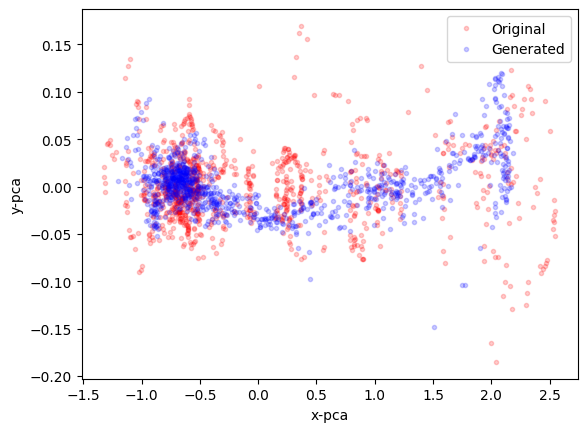

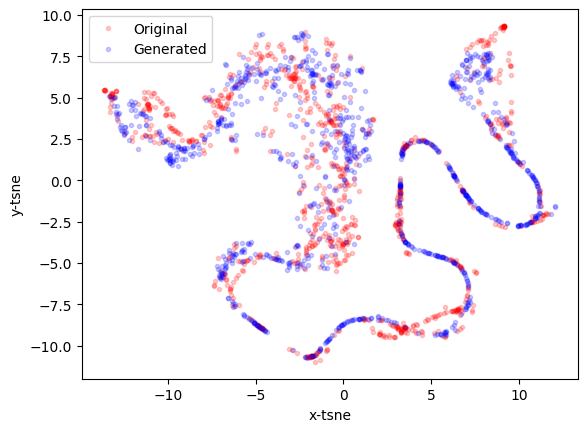

In [58]:
#Plot real and generated distributions
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'pca'), 'pca')
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'tsne'), 'tsne')